In [2]:
from jax.scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import numpy as np
import optax
from PIL import Image
import jax.numpy as jnp
import jax
from drawingwithgaussians.rendering2d import rasterize, pixel_loss

seed = 1
key = jax.random.key(seed)

ImportError: attempted relative import with no known parent package

In [ ]:
path = '/Users/gleb/Downloads/artem.jpg'
target_image = jnp.array(Image.open(path).resize((128, 128)), dtype=jnp.float32)[:, :, :3] / 255

In [ ]:
height = 128
width = 128
angle = 0.
num_gaussians = 20
lr = 1e-3

canvas = jnp.zeros((height, width, 3), dtype=jnp.float32)
means = jax.random.uniform(key, (num_gaussians, 2), minval=0, maxval=height, dtype=jnp.float32)
covariances = jnp.stack([jnp.diag(sigma**2) for sigma in jax.random.uniform(key, (num_gaussians, 2), minval=10, maxval=50, dtype=jnp.float32)])
colors = jnp.clip(jax.random.uniform(key, (num_gaussians, 4)), 0, 1)
colors = colors.at[:, 3].set(colors[:, 3] / colors[:, 3].sum())
r = R.from_euler('x', [angle,])
rotmats = jnp.repeat(r.as_matrix()[1:, 1:][None], num_gaussians, axis=0)

optimize_means = optax.adam(lr)
optimize_cov = optax.adam(lr)
optimize_colors = optax.adam(lr)
optimize_rotmats = optax.adam(lr)

opt_state_means = optimize_means.init(means)
opt_state_cov = optimize_cov.init(covariances)
opt_state_colors = optimize_colors.init(colors)
opt_state_rotmats = optimize_rotmats.init(rotmats)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


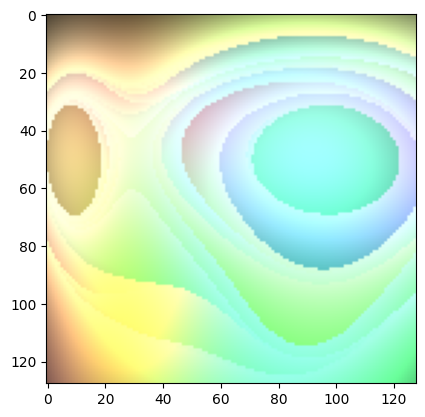

In [ ]:
renderred_gaussians = rasterize(means, covariances, jnp.clip(colors, 0, 1), rotmats, height, width)
plt.imshow(renderred_gaussians)

In [ ]:
for step in range(300):
    loss, gradients = jax.value_and_grad(pixel_loss, argnums=[0, 1, 2, 3])(means, covariances, colors, rotmats, target_image)
    updates_means, opt_state_means = optimize_means.update(gradients[0], opt_state_means)
    means = optax.apply_updates(means, updates_means)

    updates_cov, opt_state_cov = optimize_cov.update(gradients[1], opt_state_cov)
    covariances = optax.apply_updates(covariances, updates_cov)

    updates_colors, opt_state_colors = optimize_colors.update(gradients[2], opt_state_colors)
    colors = optax.apply_updates(colors, updates_colors)

    updates_rotmats, opt_state_rotmats = optimize_colors.update(gradients[3], opt_state_rotmats)
    rotmats = optax.apply_updates(rotmats, updates_rotmats)

    if step % 50 == 0:
        print(loss)


0.5818858
0.5462855
0.49153733
0.41553342
0.34119198
0.2767098
0.22837378
0.1904931
0.15984847
0.13654682
0.11795214
0.102740854
0.089955516
nan
nan
nan
nan
nan
nan
nan


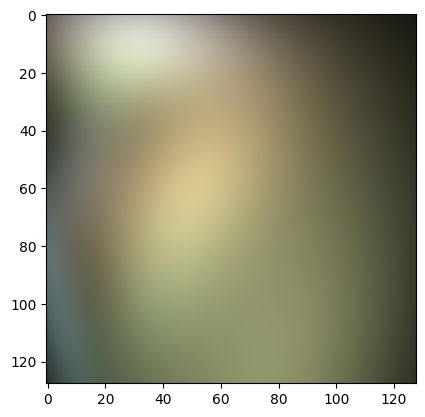

In [ ]:
renderred_gaussians = rasterize(means, covariances, jnp.clip(colors, 0, 1), rotmats, height, width)
plt.imshow(renderred_gaussians)